In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
#pip install xgboost

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_text

## DataSet

In [4]:
data = pd.read_csv("housing.csv")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
data.shape

(20640, 10)

## Preparing the dataset

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.

**- First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'**

In [6]:
data["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [7]:
df_sub = data[data["ocean_proximity"].isin(["<1H OCEAN", "INLAND"])]
df_sub.shape

(15687, 10)

In [8]:
df_sub["ocean_proximity"].unique()

array(['<1H OCEAN', 'INLAND'], dtype=object)

**- Fill missing values with zeros.**

In [9]:
df_sub.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [10]:
df_sub["total_bedrooms"].fillna(0, inplace=True)

C:\Users\salma\AppData\Local\Temp\ipykernel_6892\3855819195.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub["total_bedrooms"].fillna(0, inplace=True)


In [11]:
df_sub.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

**- Apply the log tranform to median_house_value**

In [12]:
df_sub["log_median_house_value"] = np.log1p(df_sub["median_house_value"])
df_sub.drop(columns="median_house_value", inplace=True)

C:\Users\salma\AppData\Local\Temp\ipykernel_6892\2208065629.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub["log_median_house_value"] = np.log1p(df_sub["median_house_value"])
C:\Users\salma\AppData\Local\Temp\ipykernel_6892\2208065629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop(columns="median_house_value", inplace=True)


**- Do train/validation/test split with 60%/20%/20% distribution.**
**- Use the train_test_split function and set the random_state parameter to 1**

In [13]:
def split_data(df, target):
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
    
    df_full_train = df_full_train.reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train[target].values
    y_val = df_val[target].values
    y_test = df_test[target].values

    del df_train[target]
    del df_val[target]
    del df_test[target]
    
    return df_full_train, df_train, df_val, df_test, y_train, y_val, y_test

In [14]:
df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = split_data(df_sub, target='log_median_house_value')

**- Use DictVectorizer(sparse=True) to turn the dataframe into matrices.**

In [15]:
dv = DictVectorizer(sparse=True)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

## Question1

Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.

Which feature is used for splitting the data?

- ocean_proximity
- total_rooms
- latitude
- population

In [16]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [17]:
y_pred = dt.predict(X_val)
y_pred

array([12.30066927, 12.30066927, 11.60680734, ..., 11.60680734,
       11.60680734, 11.60680734])

In [18]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



Feature used for splitting the data is **ocean_proximity**

## Question2

Train a random forest model with these parameters:

- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)

In [19]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

In [20]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [21]:
y_pred_val = rf.predict(X_val)

In [22]:
mse_val = mean_squared_error(y_val, y_pred_val)
rmse_val = np.sqrt(mse_val)
print(rmse_val)

0.24527740463893763


The RMSE of this model on validation is **0.245**

## Question3

In [23]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred_val = rf.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    
    scores.append((n, round(rmse_val,3)))

In [24]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

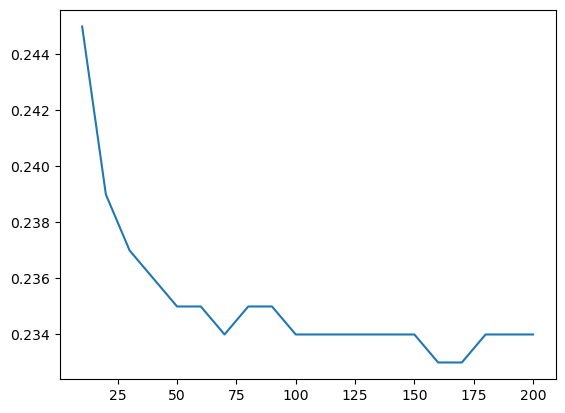

In [25]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [26]:
df_scores["rmse"].min()

0.233

In [27]:
df_scores

,n_estimators,rmse
0,10,0.245
1,20,0.239
2,30,0.237
3,40,0.236
4,50,0.235
5,60,0.235
6,70,0.234
7,80,0.235
8,90,0.235
9,100,0.234


After n_estimators = 160, RMSE stop improving.

## Question4

Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values,
- try different values of n_estimators from 10 till 200 (with step 10)
- calculate the mean RMSE
- Fix the random seed: random_state=1

In [28]:
scores = []

for max_d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        
        rf = RandomForestRegressor(max_depth=max_d, n_estimators=n, random_state=1)
        rf.fit(X_train, y_train)

        y_pred_val = rf.predict(X_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    
        scores.append((max_d, n, rmse_val))

In [29]:
df_scores2 = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])

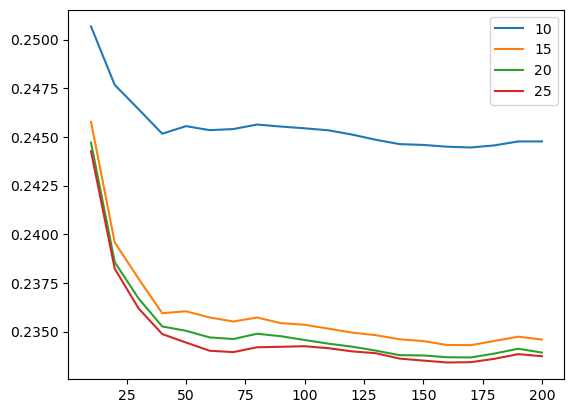

In [30]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores2[df_scores2.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

The best max_depth is **25**

## Question5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parameters:

- n_estimators=10,
- max_depth=20,
- random_state=1,
- n_jobs=-1 (optional)

Get the feature importance information from this mode

In [31]:
rf_f = RandomForestRegressor(n_estimators=10, max_depth=20,
                            random_state=1, n_jobs=-1)

rf_f.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [32]:
rf_f.feature_importances_

array([0.0151361 , 0.03031726, 0.10200703, 0.08624381, 0.33561113,
       0.29247297, 0.07380644, 0.02713606, 0.01585222, 0.02141699])

In [33]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf_f.feature_importances_
df_importances

,feature,importance
0,households,0.015136
1,housing_median_age,0.030317
2,latitude,0.102007
3,longitude,0.086244
4,median_income,0.335611
5,ocean_proximity=<1H OCEAN,0.292473
6,ocean_proximity=INLAND,0.073806
7,population,0.027136
8,total_bedrooms,0.015852
9,total_rooms,0.021417


In [34]:
df_importances.sort_values(by='importance', ascending=False)

,feature,importance
4,median_income,0.335611
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.102007
3,longitude,0.086244
6,ocean_proximity=INLAND,0.073806
1,housing_median_age,0.030317
7,population,0.027136
9,total_rooms,0.021417
8,total_bedrooms,0.015852
0,households,0.015136


The most important feature is **median_income**

## Question6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

Now change eta from 0.3 to 0.1.

In [35]:
features = dv.feature_names_
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [36]:
features = dv.feature_names_

features_clean = [re.sub(r"<|\s|=", '_', f.lower()) for f in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features_clean)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features_clean)

In [37]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [38]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [39]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [40]:
scores  = {}

In [41]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [42]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [43]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

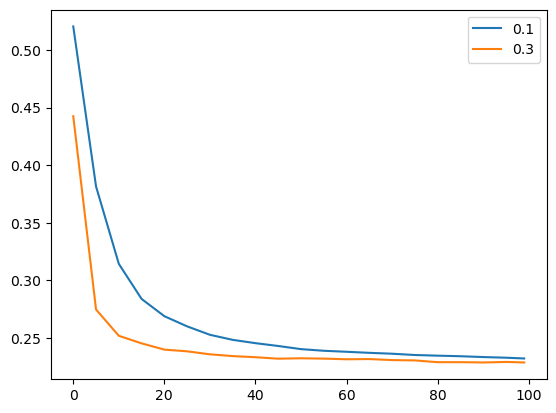

In [44]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()

both of them